In [1]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import pandas as pd
import numpy as np
import seaborn as sns
import string

In [2]:
poems = defaultdict(list)

### Reading Dataset and creating dataframe

In [3]:
with open('robert_frost.txt') as f:
    poems['text'] = f.readlines()

In [4]:
len(poems['text'])

1581

In [5]:
poems['labels'] = ['Robert Frost']*len(poems['text'])

In [6]:
with open('edgar_allan_poe.txt') as f:
    l = f.readlines()

In [7]:
poems['text'] = poems['text'] + l

In [8]:
poems['labels'] = poems['labels'] + ['Edgar Allan Poe']*len(l)

In [9]:
poems = pd.DataFrame.from_dict(poems)
poems

,text,labels
0,"Two roads diverged in a yellow wood,\n",Robert Frost
1,And sorry I could not travel both\n,Robert Frost
2,"And be one traveler, long I stood\n",Robert Frost
3,And looked down one as far as I could\n,Robert Frost
4,To where it bent in the undergrowth; \n,Robert Frost
...,...,...
2373,To a discordant melody;\n,Edgar Allan Poe
2374,"While, like a rapid ghastly river,\n",Edgar Allan Poe
2375,"Through the pale door,\n",Edgar Allan Poe
2376,"A hideous throng rush out forever,\n",Edgar Allan Poe


In [10]:
# Noticed Empty String
len(poems.loc[768]['text'])

1

In [11]:
print(poems.loc[768]['text'])

### Function to remove common punctuation and lower case the sentence

In [12]:
# Removing newline character and lowering the case
poems['text'] = poems['text'].apply(lambda x : x.rstrip().lower())

# Removing the Punctuation 
poems['text'] = poems['text'].apply(lambda x : x.translate(str.maketrans('','',string.punctuation)))

In [13]:
poems

,text,labels
0,two roads diverged in a yellow wood,Robert Frost
1,and sorry i could not travel both,Robert Frost
2,and be one traveler long i stood,Robert Frost
3,and looked down one as far as i could,Robert Frost
4,to where it bent in the undergrowth,Robert Frost
...,...,...
2373,to a discordant melody,Edgar Allan Poe
2374,while like a rapid ghastly river,Edgar Allan Poe
2375,through the pale door,Edgar Allan Poe
2376,a hideous throng rush out forever,Edgar Allan Poe


### Drop Empty Strings from the dataframe

In [14]:
poems.loc[poems['text']=='']

,text,labels
5,,Robert Frost
11,,Robert Frost
17,,Robert Frost
23,,Robert Frost
28,,Robert Frost
...,...,...
2333,,Edgar Allan Poe
2342,,Edgar Allan Poe
2351,,Edgar Allan Poe
2360,,Edgar Allan Poe


In [15]:
poems = poems.drop(poems.loc[poems['text']==''].index)
poems.loc[poems['text']=='']

,text,labels


In [16]:
poems['labels'].value_counts()

Robert Frost       1436
Edgar Allan Poe     718
Name: labels, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='count'>

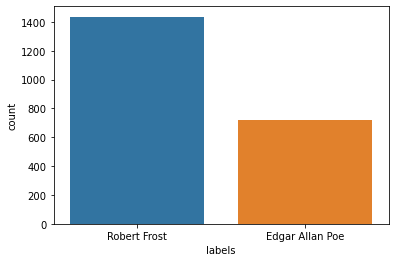

In [17]:
sns.countplot(data=poems,x='labels')
# From the graph below we can see that the data is imbalanced

In [18]:
y = poems['labels']

### Splitting the Data into train and test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(poems, y, test_size=0.3, random_state=101)

In [20]:
y_train.value_counts()

Robert Frost       999
Edgar Allan Poe    508
Name: labels, dtype: int64

In [21]:
X_train

,text,labels
1546,john threw the door wide but he didnt enter,Robert Frost
302,that as a witch id often milk a bat,Robert Frost
2340,along the ramparts plumed and pallid,Edgar Allan Poe
1178,drink and be whole again beyond confusion,Robert Frost
140,one lizard at the end of every ray,Robert Frost
...,...,...
693,the faintest restless rustling ran all through...,Robert Frost
1762,of all who hail thy presence as the morning,Edgar Allan Poe
1501,cant you and i get to the root of it,Robert Frost
1702,plumes till they trailed in the dust,Edgar Allan Poe


### Mapping unique words (Training set) to index and frequency counter

In [22]:
index = 0
vocab = {}
vocab_freq = defaultdict(int)

for sentc in X_train['text']:
    words = sentc.split()
    for word in words:
        vocab_freq[word]+=1
        if word not in vocab.keys():
            vocab[word] = index
            index+=1
len(vocab)

2413

In [23]:
total_states = len(vocab)

In [24]:
total_words = np.sum(list(vocab_freq.values()))
total_words

10947

## Creating State transition matrix for both poets and initialisation state distribution

In [25]:
matrix_robert = np.zeros((total_states,total_states))
matrix_edgar = np.zeros((total_states,total_states))

pi_robert_frost = np.zeros(total_states)
pi_edgar = np.zeros(total_states)

### Function to fill state transition matrix and initial state distribution

In [26]:
list(X_train['labels'].unique())

['Robert Frost', 'Edgar Allan Poe']

In [27]:
def filler(dataframe : pd.DataFrame,A,pi,category : str):
    
    for text in dataframe.groupby('labels').get_group(category)['text']:
        
        words = text.split()
        current = words[0]
        pi[vocab[current]]+=1
        
        for index in range(1,len(words)):
            A[vocab[current]][vocab[words[index]]]+=1
            current = words[index]
    

### Initial State Distribution

In [28]:
# variables necessary for probability Smoothing
epsilon = 0.001
sequence_len = len(X_train['text'])

In [29]:
filler(X_train,matrix_robert,pi_robert_frost,'Robert Frost')
filler(X_train,matrix_edgar,pi_edgar,'Edgar Allan Poe')

### Probability Smoothing and applying log probability to inital state distribution

In [30]:
pi_robert_frost = pi_robert_frost + epsilon
pi_robert_frost = np.log10(pi_robert_frost/(sequence_len + epsilon*total_states))

In [31]:
pi_edgar = pi_edgar + epsilon
pi_edgar = np.log10(pi_edgar/(sequence_len + epsilon*total_states))

In [32]:
pi_robert_frost[:10]

array([-2.877561  , -6.17880809, -1.4153726 , -6.17880809, -6.17880809,
       -1.61059462, -1.76381803, -6.17880809, -6.17880809, -1.83636567])

In [33]:
pi_edgar[:10]

array([-6.17880809, -6.17880809, -1.67364454, -6.17880809, -6.17880809,
       -2.09959065, -6.17880809, -6.17880809, -6.17880809, -1.94833362])

### State Transition Matrix

In [34]:
np.sum(matrix_edgar>0)

2048

In [35]:
np.sum(matrix_robert>0)

5226

### Probability Smoothing and applying log probability to State Transition matrix

In [36]:
matrix_robert  = matrix_robert + epsilon
matrix_robert = matrix_robert/(matrix_robert.sum(axis=1,keepdims=True) + epsilon*total_states)
matrix_robert = np.log10(matrix_robert)
matrix_robert

array([[-3.94576392, -0.94532985, -3.94576392, ..., -3.94576392,
        -3.94576392, -3.94576392],
       [-3.76537048, -3.76537048, -0.7649364 , ..., -3.76537048,
        -3.76537048, -3.76537048],
       [-5.60295588, -5.60295588, -5.60295588, ..., -5.60295588,
        -2.60252181, -5.60295588],
       ...,
       [-3.68358732, -3.68358732, -3.68358732, ..., -3.68358732,
        -3.68358732, -3.68358732],
       [-3.76537048, -3.76537048, -3.76537048, ..., -3.76537048,
        -3.76537048, -3.76537048],
       [-3.68358732, -3.68358732, -3.68358732, ..., -3.68358732,
        -3.68358732, -3.68358732]])

In [37]:
matrix_edgar = matrix_edgar + epsilon
matrix_edgar = matrix_edgar/(matrix_edgar.sum(axis=1,keepdims=True) + epsilon*total_states)
matrix_edgar = np.log10(matrix_edgar)
matrix_edgar

array([[-3.68358732, -3.68358732, -3.68358732, ..., -3.68358732,
        -3.68358732, -3.68358732],
       [-3.68358732, -3.68358732, -3.68358732, ..., -3.68358732,
        -3.68358732, -3.68358732],
       [-5.37442938, -5.37442938, -5.37442938, ..., -5.37442938,
        -5.37442938, -5.37442938],
       ...,
       [-3.76537048, -3.76537048, -3.76537048, ..., -3.76537048,
        -3.76537048, -3.76537048],
       [-3.68358732, -3.68358732, -3.68358732, ..., -3.68358732,
        -3.68358732, -3.68358732],
       [-3.76537048, -3.76537048, -3.76537048, ..., -3.76537048,
        -3.76537048, -3.76537048]])

### Calculating Priors for the classes present

In [38]:
priors_robert = len(X_train.loc[X_train['labels']=='Robert Frost'])/len(X_train['labels'])
priors_robert = np.log10(priors_robert)
priors_robert

-0.1785477640886495

In [39]:
priors_edgar = len(X_train.loc[X_train['labels']=='Edgar Allan Poe'])/len(X_train['labels'])
priors_edgar = np.log10(priors_edgar)
priors_edgar

-0.4722495400307125

### Function to predict X_test labels

In [40]:
def evaluate(sentc : str)->str:
    
    words = sentc.split()
    
    eval_robert_frost = priors_robert
    eval_edgar = priors_edgar
    
    # checking if the word is present in the vocabulary or not
    if words[0] in vocab.keys():
        eval_robert_frost+=pi_robert_frost[vocab[words[0]]]
        eval_edgar+=pi_edgar[vocab[words[0]]]
    else :
        eval_robert_frost+=np.log10(epsilon/(sequence_len + epsilon*total_states))
        eval_edgar+=np.log10(epsilon/(sequence_len + epsilon*total_states))
    
    
    for idx in range(1,len(words)):
        
        # checking if the word is present in the vocabulary or not
        if (words[idx-1] not in vocab.keys()) or (words[idx] not in vocab.keys()):
            eval_robert_frost+=np.log10(1/total_states)
            eval_edgar+=np.log10(1/total_states)
        else:
            eval_robert_frost+=matrix_robert[vocab[words[idx-1]]][vocab[words[idx]]]
            eval_edgar+=matrix_edgar[vocab[words[idx-1]]][vocab[words[idx]]]

    if eval_robert_frost>=eval_edgar:
        return 'Robert Frost'
    
    return 'Edgar Allan Poe'
    

In [41]:
X_test['y pred'] = X_test['text'].apply(evaluate)

In [42]:
X_test

,text,labels,y pred
408,as long ago as that,Robert Frost,Edgar Allan Poe
1251,then cane one knock,Robert Frost,Edgar Allan Poe
144,when the heat slowly hazes and the sun,Robert Frost,Robert Frost
807,i judged that such a crystal chill,Robert Frost,Robert Frost
342,like no she aint come back from kiting yet,Robert Frost,Robert Frost
...,...,...,...
200,according as he feared to risk,Robert Frost,Edgar Allan Poe
1832,in the fever of a minute,Edgar Allan Poe,Edgar Allan Poe
1280,beyond which god is,Robert Frost,Robert Frost
1273,and spoke of the lettered,Robert Frost,Robert Frost


### Checking the performace and F1 score

In [43]:
print(classification_report(y_pred=X_test['y pred'],y_true=y_test))

                 precision    recall  f1-score   support

Edgar Allan Poe       0.65      0.64      0.65       210
   Robert Frost       0.83      0.83      0.83       437

       accuracy                           0.77       647
      macro avg       0.74      0.74      0.74       647
   weighted avg       0.77      0.77      0.77       647



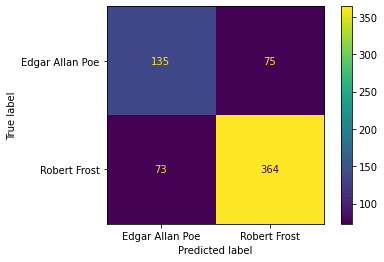

In [44]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred=X_test['y pred'],y_true=y_test),display_labels=['Edgar Allan Poe','Robert Frost']).plot()